# Miniproject #1: Classification and Regression

**Florian BARRAL**

florian.barral@student.ecp.fr

## Getting Started

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

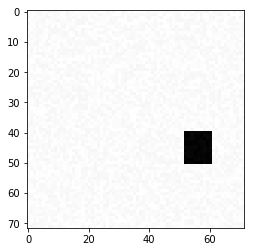

In [2]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

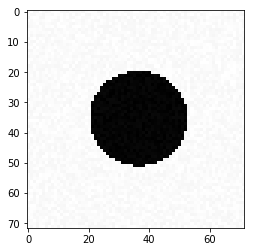

In [3]:
im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

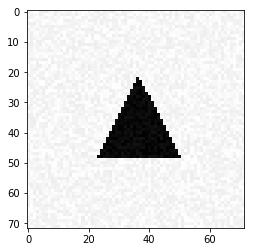

In [4]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

In [5]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y] #return pixels and categorgy for as many as samples there are

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

## Simple Classification

In [6]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Stochastic Gradient Descent Model

In [7]:
#Generate the training set
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [8]:
X_train

array([[ 0.96492439,  0.9387399 ,  0.97027331, ...,  0.95881134,
         0.93918551,  0.97234818],
       [ 0.93587204,  0.95998769,  0.94186368, ...,  0.97521903,
         0.97372043,  0.97846004],
       [ 0.99098417,  0.98940963,  0.96896974, ...,  0.98382374,
         0.96852382,  0.9357522 ],
       ..., 
       [ 0.99421424,  0.96782062,  0.93536704, ...,  0.96515484,
         0.93631274,  0.98143081],
       [ 0.99221801,  0.99896281,  0.9835832 , ...,  0.94810301,
         0.97343487,  0.98713311],
       [ 0.96031414,  0.93827743,  0.97663508, ...,  0.99571788,
         0.96437165,  0.94890615]])

In [9]:
Y_train

array([ 1.,  1.,  2.,  0.,  1.,  2.,  2.,  1.,  1.,  2.,  1.,  2.,  0.,
        0.,  0.,  1.,  2.,  1.,  2.,  2.,  0.,  1.,  0.,  0.,  2.,  2.,
        1.,  1.,  2.,  0.,  1.,  0.,  2.,  1.,  2.,  0.,  2.,  2.,  2.,
        0.,  2.,  2.,  1.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
        1.,  2.,  0.,  0.,  1.,  2.,  2.,  0.,  0.,  2.,  2.,  0.,  0.,
        2.,  1.,  1.,  0.,  1.,  1.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
        0.,  2.,  2.,  1.,  0.,  2.,  1.,  1.,  0.,  2.,  1.,  2.,  0.,
        2.,  1.,  2.,  2.,  1.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,
        2.,  0.,  2.,  1.,  0.,  1.,  2.,  1.,  0.,  1.,  1.,  2.,  0.,
        0.,  1.,  1.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  2.,  1.,
        0.,  0.,  1.,  1.,  1.,  2.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  1.,  1.,  2.,  2.,  1.,  2.,  0.,  0.,  2.,  0.,  0.,
        1.,  0.,  1.,  1.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,  2

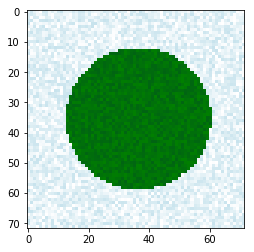

In [10]:
plt.imshow(X_train[0].reshape(72,72), cmap='ocean')

In [11]:
#Loading model
model_1= Sequential()

#Loading input
input_shape=(X_train.shape[1],)

#Loading layers
model_1.add(Dense(100,activation = "relu",input_shape = input_shape))
model_1.add(Dense(100,activation = "relu"))
model_1.add(Dense(3,activation = "softmax"))

#Compiling model with default learning rate of 0.01
model_1.compile(optimizer="sgd",loss='categorical_crossentropy', metrics = ['accuracy'])

#Fitting model
target = to_categorical(Y_train)
model_1.fit(X_train, target,validation_split =0.2, epochs = 100)#, callbacks= [early_stopping_monitor])

Train on 240 samples, validate on 60 samples
Epoch 1/100
240/240 [==============================] - 0s 518us/step - loss: 1.2462 - acc: 0.4125 - val_loss: 1.4588 - val_acc: 0.2500
Epoch 2/100
240/240 [==============================] - 0s 337us/step - loss: 1.0423 - acc: 0.4250 - val_loss: 0.9918 - val_acc: 0.4667
Epoch 3/100
240/240 [==============================] - 0s 397us/step - loss: 1.0276 - acc: 0.4333 - val_loss: 0.8632 - val_acc: 0.6000
Epoch 4/100
240/240 [==============================] - 0s 269us/step - loss: 0.8900 - acc: 0.5833 - val_loss: 0.7217 - val_acc: 0.6500
Epoch 5/100
240/240 [==============================] - 0s 232us/step - loss: 0.8105 - acc: 0.6083 - val_loss: 0.7334 - val_acc: 0.6833
Epoch 6/100
240/240 [==============================] - 0s 240us/step - loss: 0.7780 - acc: 0.6333 - val_loss: 0.9022 - val_acc: 0.4667
Epoch 7/100
240/240 [==============================] - 0s 211us/step - loss: 0.7947 - acc: 0.6458 - val_loss: 0.6699 - val_acc: 0.6833
Epoch 8/10

Epoch 61/100
240/240 [==============================] - 0s 289us/step - loss: 0.1888 - acc: 0.9625 - val_loss: 0.3640 - val_acc: 0.8167
Epoch 62/100
240/240 [==============================] - 0s 248us/step - loss: 0.2387 - acc: 0.8708 - val_loss: 0.2717 - val_acc: 0.8500
Epoch 63/100
240/240 [==============================] - 0s 346us/step - loss: 0.2988 - acc: 0.8708 - val_loss: 0.1712 - val_acc: 0.9000
Epoch 64/100
240/240 [==============================] - 0s 348us/step - loss: 0.1594 - acc: 0.9208 - val_loss: 0.6147 - val_acc: 0.8167
Epoch 65/100
240/240 [==============================] - 0s 328us/step - loss: 0.2296 - acc: 0.9042 - val_loss: 0.1904 - val_acc: 0.9167
Epoch 66/100
240/240 [==============================] - 0s 335us/step - loss: 0.3223 - acc: 0.8542 - val_loss: 0.3179 - val_acc: 0.8500
Epoch 67/100
240/240 [==============================] - 0s 294us/step - loss: 0.1730 - acc: 0.9500 - val_loss: 0.1722 - val_acc: 0.9000
Epoch 68/100
240/240 [==========================

In [12]:
#Loading model
model_2= Sequential()

#Loading input
input_shape=(X_train.shape[1],)

#Loading layers - 1 hidden layer chosen here
model_2.add(Dense(100,activation = "relu",input_shape = input_shape))
model_2.add(Dense(100,activation = "relu"))
model_2.add(Dense(3,activation = "softmax"))

#Compiling model
model_2.compile(optimizer="adam",loss='categorical_crossentropy', metrics = ['accuracy'])#for classification, loss='categorical_crossentropy'

# Optional - Defining patience of the model
#early_stopping_monitor = EarlyStopping(patience = 6)

#Fitting model
target = to_categorical(Y_train)
model_2.fit(X_train, target, validation_split = 0.2, epochs = 30, batch_size= 32)#, callbacks= [early_stopping_monitor])

Train on 240 samples, validate on 60 samples
Epoch 1/30
240/240 [==============================] - 0s 677us/step - loss: 2.0976 - acc: 0.4125 - val_loss: 0.8963 - val_acc: 0.6000
Epoch 2/30
240/240 [==============================] - 0s 322us/step - loss: 0.8265 - acc: 0.6042 - val_loss: 0.6657 - val_acc: 0.7500
Epoch 3/30
240/240 [==============================] - 0s 416us/step - loss: 0.6789 - acc: 0.6208 - val_loss: 0.4242 - val_acc: 0.7833
Epoch 4/30
240/240 [==============================] - 0s 499us/step - loss: 0.5724 - acc: 0.6875 - val_loss: 0.4998 - val_acc: 0.7500
Epoch 5/30
240/240 [==============================] - 0s 419us/step - loss: 0.6130 - acc: 0.6708 - val_loss: 0.3733 - val_acc: 0.9333
Epoch 6/30
240/240 [==============================] - 0s 390us/step - loss: 0.3895 - acc: 0.8458 - val_loss: 0.3214 - val_acc: 0.9333
Epoch 7/30
240/240 [==============================] - 0s 402us/step - loss: 0.3614 - acc: 0.8625 - val_loss: 0.3147 - val_acc: 0.8667
Epoch 8/30
240/24

In [13]:
# Testing
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model_1.predict(X_test)

array([[ 1.,  0.,  0.]], dtype=float32)

In [14]:
model_2.predict(X_test)

array([[ 1.,  0.,  0.]], dtype=float32)

In [22]:
model_1.get_weights()[0].shape,model_1.get_weights()[1].shape,model_1.get_weights()[2].shape,model_1.get_weights()[3].shape,model_1.get_weights()[4].shape,model_1.get_weights()[5].shape

((5184, 100), (100,), (100, 100), (100,), (100, 3), (3,))

## Visualization of the Solution

### Stochastic Gradient Descent

In [23]:
[weights_1,weights_2,weights_3,weights_4,weights_5,weights_6_sgd] = model_1.get_weights()

In [24]:
dot_sgd = np.dot(weights_1,weights_3)
total_dot_sgd = np.dot(dot_sgd,weights_5)
sgd_shape = total_dot_sgd.reshape(72,72,-1)

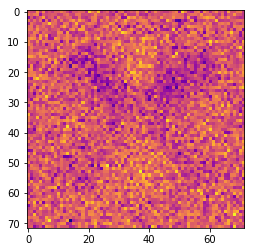

In [25]:
plt.imshow(sgd_shape[:,:,0] , cmap='plasma')

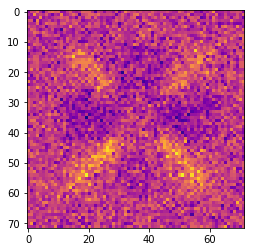

In [26]:
plt.imshow(sgd_shape[:,:,1] , cmap='plasma')

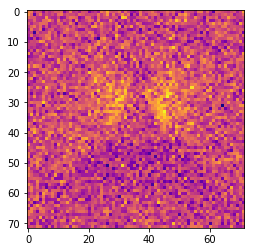

In [27]:
plt.imshow(sgd_shape[:,:,2] , cmap='plasma')

### Adam


In [28]:
[weights_1,weights_2,weights_3,weights_4,weights_5,weights_6_sgd] = model_2.get_weights()

In [29]:
dot_adam = np.dot(weights_1,weights_3)
total_dot_adam = np.dot(dot_adam,weights_5)
adam_shape = total_dot_adam.reshape(72,72,-1)

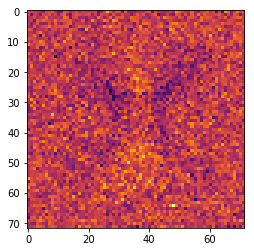

In [30]:
plt.imshow(adam_shape[:,:,0] , cmap='inferno')

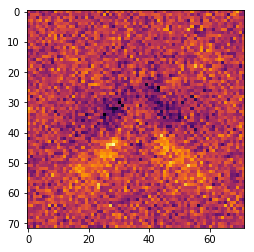

In [31]:
plt.imshow(adam_shape[:,:,1] , cmap='inferno')

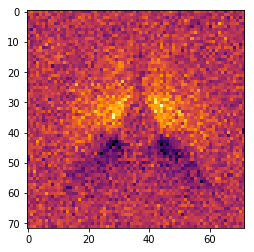

In [32]:
plt.imshow(adam_shape[:,:,2] , cmap='inferno')

## A More Difficult Classification Problem

In [33]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [42]:
%%capture
#Generating a new training and a testing set, bigger than the original one
[new_X_train, new_Y_train] = generate_dataset_classification(600, 20, True)
[new_X_test, new_Y_test] = generate_test_set_classification()

In [43]:
new_X_train.shape,new_Y_train.shape, new_X_test.shape, new_Y_test.shape

((600, 5184), (600,), (300, 5184), (300, 3))

In [44]:
# Loading model
model_Adam= Sequential()

#Loading input
input_shape=(new_X_train.shape[1],)

#Loading layers - O hidden layer chosen here
model_Adam.add(Dense(100,activation = "linear",input_shape = input_shape))#
model_Adam.add(LeakyReLU(alpha=0.1))
model_Adam.add(Dense(100,activation = "linear"))
model_Adam.add(LeakyReLU(alpha=0.1))
model_Adam.add(Dense(100,activation = "linear"))
model_Adam.add(LeakyReLU(alpha=0.1))
model_Adam.add(Dense(100,activation = "linear"))
model_Adam.add(LeakyReLU(alpha=0.1))
model_Adam.add(Dense(100,activation = "linear"))
model_Adam.add(LeakyReLU(alpha=0.1))
model_Adam.add(Dense(3,activation = "softmax"))

#Compiling model
model_Adam.compile(optimizer="adam",loss='categorical_crossentropy', metrics = ['accuracy'])


#Fitting model
target = to_categorical(new_Y_train)
model_Adam.fit(new_X_train, target, validation_split = 0.2, epochs = 100)

Train on 480 samples, validate on 120 samples
Epoch 1/100
480/480 [==============================] - 1s 1ms/step - loss: 1.2729 - acc: 0.3021 - val_loss: 1.1114 - val_acc: 0.3000
Epoch 2/100
480/480 [==============================] - 0s 439us/step - loss: 1.1136 - acc: 0.3771 - val_loss: 1.0557 - val_acc: 0.4417
Epoch 3/100
480/480 [==============================] - 0s 433us/step - loss: 1.1380 - acc: 0.3063 - val_loss: 1.1630 - val_acc: 0.2750
Epoch 4/100
480/480 [==============================] - 0s 436us/step - loss: 1.0630 - acc: 0.4042 - val_loss: 1.0648 - val_acc: 0.3667
Epoch 5/100
480/480 [==============================] - 0s 455us/step - loss: 0.9919 - acc: 0.4583 - val_loss: 1.1070 - val_acc: 0.4500
Epoch 6/100
480/480 [==============================] - 0s 408us/step - loss: 0.9095 - acc: 0.5417 - val_loss: 0.8866 - val_acc: 0.5500
Epoch 7/100
480/480 [==============================] - 0s 442us/step - loss: 0.8945 - acc: 0.5125 - val_loss: 0.8950 - val_acc: 0.6167
Epoch 8/100

Epoch 61/100
480/480 [==============================] - 0s 476us/step - loss: 0.5398 - acc: 0.7438 - val_loss: 0.7266 - val_acc: 0.6417
Epoch 62/100
480/480 [==============================] - 0s 385us/step - loss: 0.5380 - acc: 0.7438 - val_loss: 0.8024 - val_acc: 0.6167
Epoch 63/100
480/480 [==============================] - 0s 389us/step - loss: 0.5502 - acc: 0.7562 - val_loss: 0.8382 - val_acc: 0.6083
Epoch 64/100
480/480 [==============================] - 0s 421us/step - loss: 0.7090 - acc: 0.6208 - val_loss: 0.7235 - val_acc: 0.5917
Epoch 65/100
480/480 [==============================] - 0s 429us/step - loss: 0.6390 - acc: 0.6792 - val_loss: 0.8811 - val_acc: 0.5833
Epoch 66/100
480/480 [==============================] - 0s 405us/step - loss: 0.6391 - acc: 0.6417 - val_loss: 0.8294 - val_acc: 0.5917
Epoch 67/100
480/480 [==============================] - 0s 442us/step - loss: 0.6212 - acc: 0.6687 - val_loss: 0.7453 - val_acc: 0.6167
Epoch 68/100
480/480 [==========================

In [45]:
model_Adam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               518500    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
__________

In [46]:
model_Adam.evaluate(new_X_test, new_Y_test)

300/300 [==============================] - 0s 171us/step


[1.0320674856503804, 0.57666666587193804]

### Generating a convolutional network

In [47]:
new_X_train.shape , new_X_test.shape, new_Y_train.shape, new_Y_test.shape

((600, 5184), (300, 5184), (600,), (300, 3))

In [48]:
#Converting to categorical variables
new_Y_train = to_categorical(new_Y_train, 3)
print(new_Y_train.shape,new_Y_test.shape)

((600, 3), (300, 3))


In [49]:
#Reshaping input data
new_X_train=new_X_train.reshape(-1,72,72,1)
new_X_test = new_X_test.reshape(-1,72,72,1)
print(new_X_train.shape,new_X_test.shape)

((600, 72, 72, 1), (300, 72, 72, 1))


In [50]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
convolutional_network = Sequential()
convolutional_network.add(Conv2D(16,(5,5),padding='same', activation ='relu', input_shape = new_X_train.shape[1:]))
convolutional_network.add(MaxPooling2D(pool_size=(2,2)))#Select the highest pixel value from a 2x2 pixel region
convolutional_network.add(Dropout(0.25))
convolutional_network.add(Flatten())
convolutional_network.add(Dense(128,activation = 'relu'))
convolutional_network.add(Dropout(0.5))
convolutional_network.add(Dense(3, activation ='softmax'))
convolutional_network.compile(optimizer='adam',loss="categorical_crossentropy", metrics = ['accuracy'])
convolutional_network.fit(new_X_train, new_Y_train, validation_split = 0.2, epochs = 30)

Train on 480 samples, validate on 120 samples
Epoch 1/30
480/480 [==============================] - 2s 5ms/step - loss: 2.5188 - acc: 0.3667 - val_loss: 1.1595 - val_acc: 0.3000
Epoch 2/30
480/480 [==============================] - 2s 5ms/step - loss: 1.1002 - acc: 0.3688 - val_loss: 1.0899 - val_acc: 0.3250
Epoch 3/30
480/480 [==============================] - 2s 4ms/step - loss: 1.0739 - acc: 0.3646 - val_loss: 1.0733 - val_acc: 0.2583
Epoch 4/30
480/480 [==============================] - 2s 4ms/step - loss: 1.0613 - acc: 0.3875 - val_loss: 1.0738 - val_acc: 0.2667
Epoch 5/30
480/480 [==============================] - 2s 4ms/step - loss: 1.0458 - acc: 0.4146 - val_loss: 1.0374 - val_acc: 0.4750
Epoch 6/30
480/480 [==============================] - 2s 4ms/step - loss: 1.0176 - acc: 0.4396 - val_loss: 1.0094 - val_acc: 0.4333
Epoch 7/30
480/480 [==============================] - 2s 4ms/step - loss: 0.9791 - acc: 0.4792 - val_loss: 0.9280 - val_acc: 0.5417
Epoch 8/30
480/480 [==========

In [51]:
convolutional_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               2654336   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 387       
Total para

In [52]:
convolutional_network.evaluate(new_X_test, new_Y_test)

300/300 [==============================] - 0s 2ms/step


[0.59930883407592772, 0.7266666674613953]

Lower loss function and higher accuracy rate with our convolutional network ! :)

## A Regression Problem